In [31]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from torch.optim import lr_scheduler
import math

In [32]:
def get_dataloader_workers():
    return 4
def load_data_CIFAR100(batch_size,train_augs=None,test_augs=None,resize=None):  
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    if train_augs == None:
        CIFAR100_train = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=True,transform=trans,download=True)
        CIFAR100_test = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=False,transform=trans,download=True)
    else:
        CIFAR100_train = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=True,transform=train_augs,download=True)
        CIFAR100_test = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=False,transform=test_augs,download=True)
    return (data.DataLoader(CIFAR100_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(CIFAR100_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

In [33]:
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(3072,1024), nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(1024, 512), nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512, 100))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=512, out_features=100, bias=True)
)

In [34]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,scheduler=None):
    net.to(device)
    optimizer = trainer
    loss = loss
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        if scheduler:
            if scheduler.__module__==lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in trainer.param_groups:
                    param_group['lr']=scheduler(epoch)
                    
            
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [35]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
        warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr


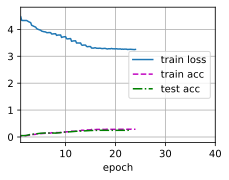

In [36]:
batch_size, lr, num_epochs = 128, 0.05, 40
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
mean = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
std = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]
train_augs =transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_augs=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
device=d2l.try_gpu()
scheduler=CosineScheduler(max_update=15,warmup_steps=5,base_lr=0.3,final_lr=0.01)
train_iter, test_iter = load_data_CIFAR100(batch_size,train_augs=train_augs,test_augs=test_augs)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,scheduler)